
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 多層パーセプトロン

:ラベル: `sec_mlp`

 :numref: `chap_classification`では、ソフトマックス回帰 (:numref: `sec_softmax` ) を導入し、アルゴリズムを最初から実装し (:numref: `sec_softmax_scratch` )、高レベル API (:numref: `sec_softmax_concise` ) を使用しました。これにより、低解像度の画像から 10 種類の衣類を認識できる分類器をトレーニングできるようになりました。その過程で、データをラングリングし、出力を有効な確率分布に強制し、適切な損失関数を適用し、モデルのパラメーターに関して損失関数を最小化する方法を学びました。単純な線形モデルのコンテキストでこれらのメカニズムを習得したので、本書が主に扱う比較的豊富なモデルであるディープ ニューラル ネットワークの探索を開始できます。


In [1]:
%matplotlib inline
import torch
from d2l import torch as d2l


## 非表示レイヤー

:numref: `subsec_linear_model`のアフィン変換は、バイアスを加えた線形変換として説明しました。まず、:numref: `fig_softmaxreg`に示されている、ソフトマックス回帰の例に対応するモデル アーキテクチャを思い出してください。このモデルは、単一のアフィン変換とそれに続くソフトマックス演算を介して入力を出力に直接マッピングします。単純なアフィン変換によってラベルが本当に入力データに関連付けられている場合は、このアプローチで十分です。ただし、(アフィン変換における) 線形性は*強力な*前提条件です。

### 線形モデルの限界

たとえば、線形性は*単調性*の*弱い*仮定を意味します。つまり、特徴量の増加は常にモデルの出力の増加を引き起こすか (対応する重みが正の場合)、常にモデルの出力の減少を引き起こすか (重みが正の場合)、常にモデルの出力の減少を引き起こす必要があります。対応する重みは負です)。それが理にかなっている場合もあります。たとえば、ある個人がローンを返済するかどうかを予測しようとしている場合、他のすべての条件が同じであれば、高収入の申込者は常に低収入の申込者よりも返済する可能性が高いと合理的に仮定できます。この関係は単調ではありますが、おそらく返済確率と直線的に関連しているわけではありません。 0 ドルから 50,000 ドルへの収入の増加は、100 万ドルから 105 万ドルへの収入の増加よりも返済可能性の大きな増加に相当すると考えられます。これに対処する 1 つの方法は、ロジスティック マップ (結果の確率の対数) を使用して、線形性がより妥当になるように結果を後処理することです。

単調性に違反する例は簡単に思いつくことに注意してください。たとえば、体温の関数として健康状態を予測したいとします。体温が 37°C (98.6°F) を超える人の場合、体温が高いほどリスクが高いことを示します。ただし、体温が 37°C 未満の人の場合、体温が低いほどリスクが高いことを示します。この場合も、37℃からの距離を特徴として使用するなど、いくつかの賢明な前処理によって問題を解決できる可能性があります。

しかし、猫と犬の画像を分類する場合はどうすればよいでしょうか?位置 (13、17) のピクセルの強度を増加すると、画像に犬が描かれている可能性が常に増加します (または常に減少します)。線形モデルへの依存は、猫と犬を区別するための唯一の要件は個々のピクセルの明るさを評価することであるという暗黙の仮定に対応します。画像を反転することでカテゴリーが維持される世界では、このアプローチは失敗する運命にあります。

ここでの線形性の明らかな不合理にもかかわらず、前の例と比較すると、単純な前処理の修正で問題に対処できるかどうかはそれほど明白ではありません。つまり、ピクセルの重要性はそのコンテキスト (周囲のピクセルの値) に複雑に依存するためです。特徴間の関連する相互作用を考慮したデータの表現が存在する可能性があり、その上で線形モデルが適していますが、それを手動で計算する方法がわかりません。ディープ ニューラル ネットワークでは、観測データを使用して、隠れ層を介した表現と、その表現に作用する線形予測子の両方を共同学習しました。

この非線形性の問題は、少なくとも 1 世紀にわたって研究されてきました :cite: `Fisher.1928` 。たとえば、最も基本的な形式のデシジョン ツリーは、一連の二分決定を使用してクラス メンバーシップを決定します (cite: `quinlan2014c4` )。同様に、カーネル メソッドは、非線形依存関係をモデル化するために何十年にもわたって使用されてきました (引用: `Aronszajn.1950` )。これは、たとえば、ノンパラメトリック スプライン モデル :cite: `Wahba.1990`やカーネル メソッド :cite: `Scholkopf.Smola.2002`に導入されています。それは脳がごく自然に解決することでもあります。結局のところ、ニューロンは他のニューロンに栄養を与え、そのニューロンは再び他のニューロンに栄養を与えます:cite: `Cajal.Azoulay.1894` 。その結果、一連の比較的単純な変換が得られます。

### 非表示レイヤーの組み込み

1 つ以上の隠れ層を組み込むことで、線形モデルの制限を克服できます。これを行う最も簡単な方法は、完全に接続された多数のレイヤーを相互に積み重ねることです。各レイヤーは、出力を生成するまで、その上のレイヤーにフィードされます。最初の $L-1$ 層は表現として、最後の層は線形予測子として考えることができます。このアーキテクチャは一般に*多層パーセプトロン*と呼ばれ、 *MLP* (:numref: `fig_mlp` ) と略されることもあります。 

![](http://d2l.ai/_images/mlp.svg) :ラベル: `fig_mlp`

この MLP には 4 つの入力、3 つの出力があり、その隠れ層には 5 つの隠れユニットが含まれています。入力層には計算が含まれないため、このネットワークで出力を生成するには、隠れ層と出力層の両方の計算を実装する必要があります。したがって、この MLP の層の数は 2 です。両方の層が完全に接続されていることに注意してください。すべての入力は隠れ層のすべてのニューロンに影響を与え、さらにこれらのそれぞれが出力層のすべてのニューロンに影響を与えます。残念ながら、まだ終わっていません。

### 線形から非線形へ

前と同様に、行列 $\mathbf{X} \in \mathbb{R}^{n \times d}$ によって、各サンプルが $d$ の入力 (特徴) を持つ $n$ サンプルのミニバッチを表します。隠れ層に $h$ 隠れユニットがある 1 隠れ層 MLP の場合、隠れ層の出力を $\mathbf{H} \in \mathbb{R}^{n \times h}$ で表します。は*隠された表現*です。隠れ層と出力層は両方とも完全に接続されているため、隠れ層の重み $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ とバイアス $\mathbf{ b}^{(1)} \in \mathbb{R}^{1 \times h}$ と出力層の重み $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ とバイアス $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$。これにより、次のように 1 隠れ層 MLP の出力 $\mathbf{O} \in \mathbb{R}^{n \times q}$ を計算できます。

 $$ \begin{aligned} \mathbf{H} &amp; = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \ \mathbf{O} &amp; = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}。 \end{整列} $$

隠れ層を追加した後、モデルでは追加のパラメーターのセットを追跡して更新する必要があることに注意してください。それで、私たちはその代わりに何を得たのでしょうか？驚くかもしれませんが、上で定義したモデルでは、*苦労しても何も得られません*。理由は明白です。上記の隠れユニットは入力のアフィン関数によって与えられ、出力 (ソフトマックス以前) は単なる隠れユニットのアフィン関数です。アフィン関数のアフィン関数は、それ自体がアフィン関数です。さらに、私たちの線形モデルはすでにあらゆるアフィン関数を表現できました。

これを正式に確認するには、上記の定義の隠れ層を折りたたむだけで、パラメータ $\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^ を持つ同等の単層モデルが得られます。 {(2)}$ および $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

 $$ \mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1) } \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}。 $$

多層アーキテクチャの可能性を実現するには、もう 1 つの重要な要素が必要です。それは、アフィン変換後に各隠れユニットに適用される非線形*活性化関数*$\sigma$ です。たとえば、一般的な選択肢は、引数を要素ごとに操作する ReLU (Rectified Linear Unit) 活性化関数 :cite: `Nair.Hinton.2010` $\sigma(x) = \mathrm{max}(0, x)$ です。アクティベーション関数 $\sigma(\cdot)$ の出力は、*アクティベーション*と呼ばれます。一般に、活性化関数を導入すると、MLP を線形モデルに折りたたむことはできなくなります。

 $$ \begin{aligned} \mathbf{H} &amp; = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \ \mathbf {O} &amp; = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\ \end{aligned} $$

 $\mathbf{X}$ の各行はミニバッチ内の例に対応するため、表記法の一部を乱用して、非線形性 $\sigma$ を定義して行単位でその入力に適用します。つまり、次の例の 1 つです。時間。 :numref: `subsec_softmax_vectorization`で行単位の演算を示すときに、softmax にも同じ表記法を使用したことに注意してください。私たちが使用する活性化関数は、行単位だけでなく要素単位にも適用されることがよくあります。これは、層の線形部分を計算した後、他の隠れユニットによって取得された値を見ることなく、各アクティベーションを計算できることを意味します。

より一般的な MLP を構築するには、このような隠れ層を積み重ね続けることができます。たとえば、 $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \ mathbf{b}^{(1)})$ および $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2) } + \mathbf{b}^{(2)})$ を重ねて、より表現力豊かなモデルを生成します。

### ユニバーサル近似器

脳は非常に高度な統計分析ができることがわかっています。したがって、ディープネットワークが*どれほど強力で*あるかを問う価値はあります。この質問は、MLP のコンテキストでの :citet: `Cybenko.1989`や、動径基底関数 (RBF) と見なせる方法でカーネル ヒルベルト空間を再現するコンテキストでの :citet: `micchelli1984interpolation`内挿など、複数回回答されています。 ) 単一の隠れ層を持つネットワーク。これら (および関連する結果) は、単一隠れ層ネットワークであっても、十分なノード (おそらく異常に多い) と適切な重みセットがあれば、あらゆる関数をモデル化できることを示唆しています。ただし、実際にその関数を学習するのは難しい部分です。ニューラル ネットワークは C プログラミング言語に少し似ていると考えるかもしれません。この言語は、他の現代言語と同様に、あらゆる計算可能なプログラムを表現できます。しかし、実際に仕様を満たすプログラムを考え出すのは難しい部分です。

さらに、単一隠れ層ネットワークがあらゆる機能を学習*できる*からといって、単一隠れ層ネットワークですべての問題を解決しようとする必要があるわけではありません。実際、この場合、カーネル法は無限次元空間であっても問題を*正確に*解決できるため、はるかに効果的です (引用: `Kimeldorf.Wahba.1971,Scholkopf.Herbrich.Smola.2001` )。実際、より深い (より広い) ネットワークを使用することで、多くの関数をよりコンパクトに近似できます:cite: `Simonyan.Zisserman.2014` 。以降の章では、より厳密な議論について触れます。

## アクティベーション関数

:label: `subsec_activation-functions`

活性化関数は、重み付けされた合計を計算し、それにさらにバイアスを加えることによって、ニューロンを活性化するかどうかを決定します。これらは入力信号を出力に変換する微分可能な演算子ですが、そのほとんどは非線形性を追加します。活性化関数は深層学習の基礎であるため (**いくつかの一般的な活性化関数を簡単に見てみましょう**)。

###  ReLU関数

実装の単純さとさまざまな予測タスクでの優れたパフォーマンスの両方により、最も一般的な選択肢は、*修正線形単位*( *ReLU* ) です (引用: `Nair.Hinton.2010` )。 [ **ReLU は非常に単純な非線形変換を提供します**]。要素 $x$ が与えられると、関数はその要素と $0$ の最大値として定義されます。

 $$\演算子名{ReLU}(x) = \max(x, 0).$$

非公式には、ReLU 関数は正の要素のみを保持し、対応するアクティベーションを 0 に設定することによってすべての負の要素を破棄します。直感を得るために、関数をプロットできます。ご覧のとおり、活性化関数は区分的に線形です。


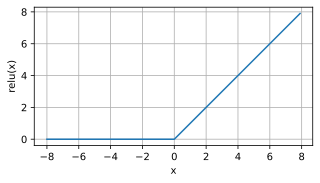

In [2]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(5, 2.5))


入力が負の場合、ReLU 関数の導関数は 0 になり、入力が正の場合、ReLU 関数の導関数は 1 になります。入力が 0 に正確に等しい値を取る場合、ReLU 関数は微分できないことに注意してください。これらの場合、デフォルトでは左側の導関数を使用し、入力が 0 のとき導関数は 0 であると言います。入力は実際には決してゼロにはならない可能性があるため、これを回避できます (数学者は、入力が 0 では微分不可能であると言うでしょう)メジャーゼロのセット）。微妙な境界条件が問題になる場合、私たちはおそらくエンジニアリングではなく (*実際の*) 数学を行っているという古い格言があります。その一般通念がここに当てはまる可能性があります。少なくとも、制約付きの最適化を実行していないという事実は当てはまります :cite: `Mangasarian.1965,Rockafellar.1970` 。以下にプロットされた ReLU 関数の導関数をプロットします。


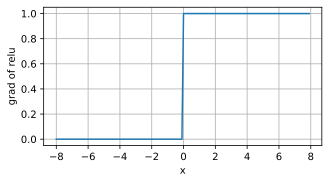

In [3]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(5, 2.5))


ReLU を使用する理由は、その派生関数が特に行儀よく動作するためです。つまり、ReLU が消えるか、単に引数を通過させるかのどちらかです。これにより、最適化の動作が向上し、以前のバージョンのニューラル ネットワークを悩ませていた勾配の消失という十分に文書化された問題が軽減されました (これについては後で詳しく説明します)。

 ReLU 関数には、*パラメーター化された ReLU* ( *pReLU* ) 関数を含む多くのバリアントがあることに注意してください:cite: `He.Zhang.Ren.ea.2015` 。このバリエーションでは ReLU に線形項を追加するため、引数が負の場合でも一部の情報は通過します。

 $$\演算子名{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### シグモイド関数

[***シグモイド関数は***、値が領域 $\mathbb{R}$ にある入力を (**区間 (0, 1) にある出力に変換します)。**そのため、シグモイドは*スカッシング*と呼ばれることがよくあります。 *function* : 範囲 (-inf, inf) 内の入力を範囲 (0, 1) 内の値に潰します。

 $$\演算子名{シグモイド}(x) = \frac{1}{1 + \exp(-x)}.$$

初期のニューラル ネットワークでは、科学者は、*発火する*か*発火しない*生物学的ニューロンをモデル化することに興味を持っていました。したがって、人工ニューロンの発明者であるマカロックとピッツにまで遡るこの分野の先駆者たちは、閾値処理ユニットに焦点を当てました:cite: `McCulloch.Pitts.1943` 。しきい値設定アクティベーションは、入力があるしきい値を下回る場合は値 0 をとり、入力がしきい値を超える場合は値 1 をとります。

勾配ベースの学習に注目が移ったとき、シグモイド関数は、しきい値処理ユニットに対する滑らかで微分可能な近似であるため、自然な選択となりました。シグモイドは、出力をバイナリ分類問題の確率として解釈したい場合に、出力ユニットの活性化関数として今でも広く使用されています。シグモイドはソフトマックスの特殊なケースと考えることができます。ただし、隠れ層でのほとんどの用途では、シグモイドのほとんどが、よりシンプルでトレーニングが容易な ReLU に置き換えられています。これの多くは、シグモイドが最適化に課題をもたらすという事実と関係があります (引用: `LeCun.Bottou.Orr.ea.1998` )。これは、大きな正*および*負の引数に対してその勾配が消失するためです。これにより、そこから抜け出すのが困難なプラトーが発生する可能性があります。それにもかかわらず、シグモイドは重要です。リカレント ニューラル ネットワークに関する後の章 (例:numref: `sec_lstm` ) では、シグモイド ユニットを利用して時間にわたる情報の流れを制御するアーキテクチャについて説明します。

以下にシグモイド関数をプロットします。入力が 0 に近い場合、シグモイド関数は線形変換に近づくことに注意してください。


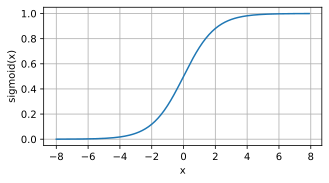

In [4]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)', figsize=(5, 2.5))


シグモイド関数の導関数は次の方程式で与えられます。

 $$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}( x)\left(1-\演算子名{シグモイド}(x)\right).$$

シグモイド関数の導関数を以下にプロットします。入力が 0 の場合、シグモイド関数の導関数は最大 0.25 に達することに注意してください。入力がいずれかの方向に 0 から発散すると、導関数は 0 に近づきます。


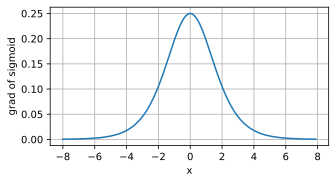

In [5]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(5, 2.5))


### タン関数

:label: `subsec_tanh`

シグモイド関数と同様に、[ **tanh (双曲線正接) 関数も入力を圧縮し**]、入力を区間 ( **-1 と 1 の間**) の要素に変換します。

 $$\演算子名{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

以下にtanh関数をプロットします。入力が 0 に近づくと、tanh 関数は線形変換に近づくことに注意してください。関数の形状はシグモイド関数の形状に似ていますが、tanh 関数は座標系の原点に関して点対称を示します (引用: `Kalman.Kwasny.1992` )。


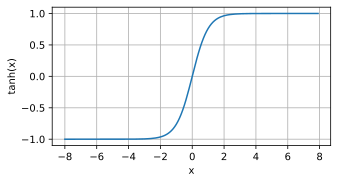

In [6]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(5, 2.5))


Tanh 関数の導関数は次のとおりです。

 $$\frac{d}{dx} \オペレーター名{tanh}(x) = 1 - \オペレーター名{tanh}^2(x).$$

それを以下にプロットします。入力が 0 に近づくと、tanh 関数の微分値は最大の 1 に近づきます。また、シグモイド関数で見たように、入力がいずれかの方向に 0 から遠ざかるにつれて、tanh 関数の微分値は 0 に近づきます。


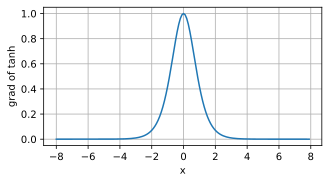

In [7]:
# Clear out previous gradients
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(5, 2.5))


## 要約と考察

非線形性を組み込んで表現力豊かな多層ニューラル ネットワーク アーキテクチャを構築する方法がわかりました。余談ですが、あなたの知識により、1990 年頃の実務家と同様のツールキットをすでに管理できるようになりました。強力なオープンソースの深層学習フレームワークを活用して構築できるため、ある意味、1990 年代に働いていた他の人よりも有利です。わずか数行のコードを使用して、モデルを迅速に作成できます。以前は、これらのネットワークをトレーニングするには、研究者が C、Fortran、または Lisp (LeNet の場合) で明示的に層と派生をコーディングする必要がありました。

 2 番目の利点は、ReLU がシグモイド関数や Tanh 関数よりも最適化に非常に適していることです。これは、過去 10 年間のディープラーニングの復活を助けた重要なイノベーションの 1 つであると主張する人もいるでしょう。ただし、活性化関数の研究はまだ終わっていないことに注意してください。たとえば、GELU (ガウス誤差線形単位) 活性化関数 $x \Phi(x)$ :cite: `Hendrycks.Gimpel.2016` 、$\Phi(x)$ は標準ガウス累積分布関数と Swish 活性化関数です。 :citet: `Ramachandran.Zoph.Le.2017`で提案されている $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ は、多くの場合により高い精度をもたらします。

## 演習
1. *線形*ディープネットワーク、つまり非線形性 $\sigma$ のないネットワークに層を追加しても、ネットワークの表現力は決して向上しないことを示します。積極的に削減する例を挙げてください。
1.  pReLU 活性化関数の導関数を計算します。
1.  Swish 活性化関数 $x \operatorname{sigmoid}(\beta x)$ の導関数を計算します。
1.  ReLU (または pReLU) のみを使用する MLP が連続区分線形関数を構築することを示します。
1. シグモイドとタンは非常によく似ています。<ol><li> $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$ であることを示します。
1. 両方の非線形性によってパラメータ化された関数クラスが同一であることを証明します。ヒント: アフィン層にはバイアス項もあります。



[ディスカッション](https://discuss.d2l.ai/t/91)
